# EDU labelling and deterministic delay

This notebook takes the previously implemented deterministic EDU experiment and adds a fixed time delay as explained in section A.2.2

Figure A3 from page 63

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

class Cell :
    
    def __init__(self, 
                 age = None, exposure_time = 0., 
                Tc = 1, TG1 = 11./24, TS = 8./24, TG2M = 5./24):
        
        # Individual phases' times
        self._TG1 = TG1 # G1
        self._TS = TS # S
        self._TG2M = TG2M # G2 + M
        self._Tc = Tc # Total cell cycle time
        
        assert Tc == TG1 + TS + TG2M
        
        # Age
        self._age = age
        
        # EDU exposure time 
        self._exposure_time = exposure_time
    
    def get_copy_number(self):
        # if cell is in G1 return 1
        if self._age <= self._TG1 :
            return 1.
        # if cell is S linearly interpolate from 1 and 2
        if (self._age > self._TG1) & (self._age <= self._TG1 + self._TS):
            copy_number = (2. - 1.)/self._TS
            copy_number *= (self._age - self._TG1)
            copy_number += 1
            assert (copy_number > 1.) & (copy_number < 2.)
            return copy_number
        # if cell is in G2 or M return 2
        if self._age > self._TG1 + self._TS:
            return 2.

        
class EDU_deterministic_experiment :
    
    def __init__(self, N_cells = 1000, T_tot = 1.3, 
                 Tc = 1., TG1 = 11./24, TS = 8./24, TG2M = 5./24,
                 time_delta = 0.):
        
        # Initial number of cells
        self._N_cells = N_cells
        self._initial_N_cells = N_cells
        
        # Individual phases' times
        self._TG1 = TG1 # G1
        self._TS = TS # S
        self._TG2M = TG2M # G2 + M
        self._Tc = Tc # Total cell cycle time
        
        assert Tc == TG1 + TS + TG2M
        
        # Total time of the experiment
        self._T_tot = T_tot
        
        # time delta (delay)
        # if exposure_time > time_delta
        # cell's are counted as EDU+
        self._time_delta = time_delta
        
        # The population is a list of cells
        self._population = []
        # generate initial population
        for _ in range(self._N_cells):
            # Sample age from ages' distribution given Tc
            age = self.sample_age(self._Tc)
            # Add a cell with that age that have no exposure time
            # In this deterministic version of the simulation
            # we have fixed phases' times
            self._population.append(
                Cell(age = age,
                     TG1 = self._TG1, TS = self._TS, 
                     TG2M = self._TG2M, Tc = self._Tc,
                     exposure_time = 0.)
            )
            
        # Results are couples (t, %EDU-positive)
        self._times = []
        self._positive_fraction = []
        
        # We also save data for copy-number histogram
        self._copy_number = []
        for cell in self._population :
            self._copy_number.append(cell.get_copy_number())
            assert (self._copy_number[-1] >= 1. ) & (self._copy_number[-1] <= 2. ) 
        
    def sample_age(self, Tc):
        # Sample random age from ages distribution
        # Accept-Reject method
        accepted = False
        while not accepted:
            # sample uniformly one age from 0 to Tc
            u = np.random.uniform(low = 0., high = Tc)
            # sample uniformly from min to max
            # values of the ages distribution
            v = np.random.uniform(low = 0., high = math.log(4)/Tc + 0.01)
            # accept or reject
            if v <= self.age_distribution(u, Tc):
                accepted = True
        # return accepted age
        return u;
    
    def age_distribution(self, a, Tc):
        # Age distribution of cells given the 
        # cell cycle lenght Tc
        return (2*math.log(2)/Tc)*math.exp(-math.log(2)*a/Tc)
    
    def run_experiment(self, N_timesteps = 100):
        
        # Times at which positive cells count is performed
        self._times = np.linspace(0., self._T_tot, num = N_timesteps)
        
        d_t = self._times[1]
        
        # For all measurement's times
        for t in self._times:
           
            new_born = 0  # New born cells counter
            new_ages = [] # ages of new cells
            new_exposure_times = [] # label-status of new cells
            
            # For all cells
            for cell in self._population:
                # add d_t to cell age
                cell._age += d_t
                
                
                # if cell is in the S phase
                if (cell._age >= cell._TG1 ) & (cell._age <= cell._TG1 + cell._TS) :
                    #add d_t to exposure_time 
                    cell._exposure_time += d_t
                
                # if the cell completed the cycle
                if cell._age > cell._Tc:
                    # the cell divide and two new cell are made
                    # total number of cell increases by one
                    self._N_cells += 1
                    
                    # daughters get half of the progenitor exposure_time
                    exposure_time = cell._exposure_time/2. 
                    
                    # the age of the new cells is the difference 
                    # between (age + t) and Tc
                    age = cell._age - cell._Tc
                    
                    # Two new cells in population are the old cell
                    # with age and exposure time set to the new one 
                    # and another new cell
                    
                    cell._age = age 
                    cell._exposure_time = exposure_time
                    
                    # we need to add a cell to population list
                    # but we can't do that during this iteration 
                    # (on population list).
                    # So we have to save total number of new born cells 
                    # to add later and their age and exposure_time
                    new_born += 1
                    new_ages.append(age)
                    new_exposure_times.append(exposure_time)
            
            # We add new cells to the population list
            #for every new cell
            for i in range(new_born):
                # we add a cell with that age and label-status
                # in this deterministic version phases' times are fixed
                self._population.append(
                    Cell(age = new_ages[i], 
                         TG1 = self._TG1, TS = self._TS, 
                         TG2M = self._TG2M, Tc = self._Tc, 
                         exposure_time = new_exposure_times[i])
                )
            
            #We then perform EDU-positive cell count 
            EDU_positive = 0
            
            for cell in self._population :
                # if exposure time > time_delta
                if cell._exposure_time > self._time_delta:
                    EDU_positive += 1
            
            # calculate EDU-positive fraction of cells
            positive_fraction = float(EDU_positive)/float(self._N_cells)
            # save result
            self._positive_fraction.append(positive_fraction)
            
    def plot_EDU(self):
        plt.plot(self._times, self._positive_fraction, label = "simualtion")
        plt.title("Deterministic EDU experiment\n"+str(self._initial_N_cells)+" initial cells")
        plt.ylabel(r"Fraction of EDU${}^+$ cells")
        plt.xlabel("Time (units of Tc)")
        
        # plot analytic estimation form explicit cell cicle
        # Eq. 8 from "EDU_labelling_dynamics"
        f = []
        for t in self._times:
            if t < self._TG2M : # t < T_G2M
                f.append(math.pow(2., (self._TG2M + self._TS)/self._Tc) 
                         - math.pow(2., (self._TG2M - t)/self._Tc)
                        )
            else: # t > T_G2M
                if t < (self._Tc - self._TS) : # T_G2M <= t < (T_c - T_S)
                    f.append(1. - (math.pow(2., (self._TG2M + self._Tc - t)/self._Tc)
                                  - math.pow(2., (self._TG2M + self._TS)/self._Tc)
                                  )
                            )
                else: # t >= (T_c - T_S)
                    f.append(1.)
        
        plt.plot(self._times, f, label = "analytic")
        
    def plot_copy_number(self, bins = 20, save = None):
        plt.figure(figsize=(5,4))
        plt.hist(self._copy_number, bins = bins)
        plt.title("Copy number - "+str(self._initial_N_cells)+" cells")
        plt.xlabel("Copy number")
        plt.ylabel("Counts")
        if save != None:
            plt.savefig(save)
        plt.show()
    
    def plot_age_distribution(self, bins = 20, save = None):
        plt.figure(figsize=(5,4))
        # plot ages istogram
        cell_ages = [cell._age for cell in self._population]
        plt.hist(cell_ages, bins = bins, label = "simulation")
        # plot age distribution n(a)
        ages = np.linspace(0,self._Tc)
        area = self._N_cells*self._Tc/bins
        distribution = [area*self.age_distribution(a,self._Tc) for a in ages]
        plt.plot(ages, distribution, color ="red", label = "distribution")
        plt.title("Age distribution - "+str(self._initial_N_cells)+" cells")
        plt.xlabel(r"Age (units of $T_c$)")
        plt.ylabel("Counts")
        if save != None:
            plt.savefig(save)
        plt.show()

. . . . . . . . . . 


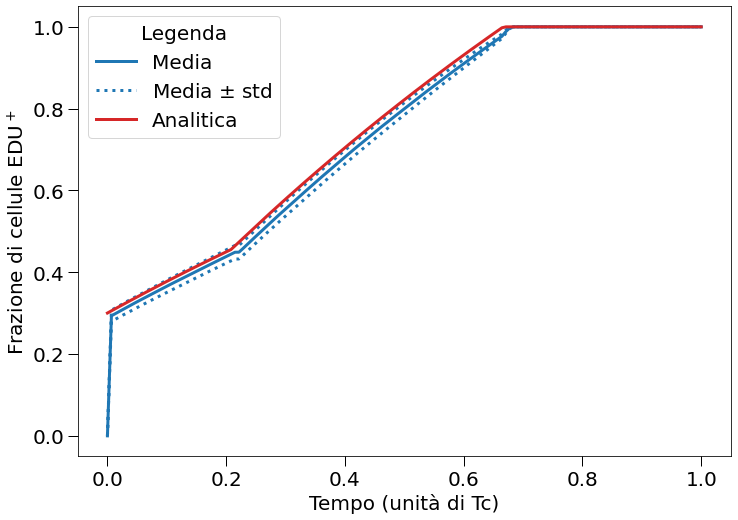

. . . . . . . . . . 


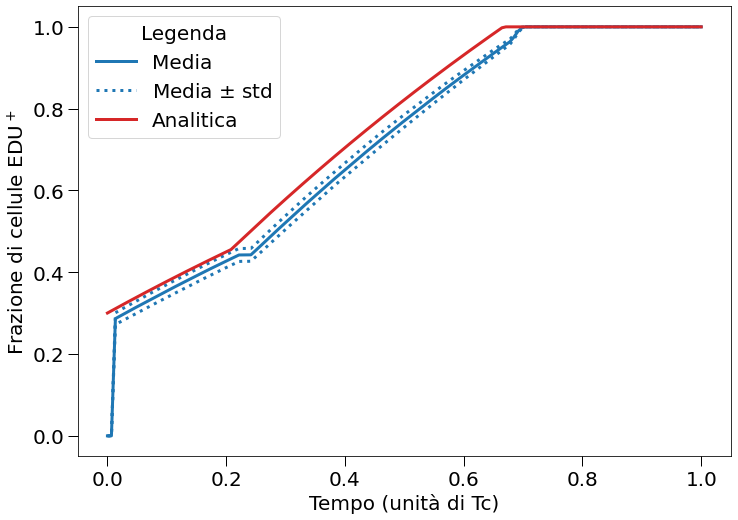

. . . . . . . . . . 


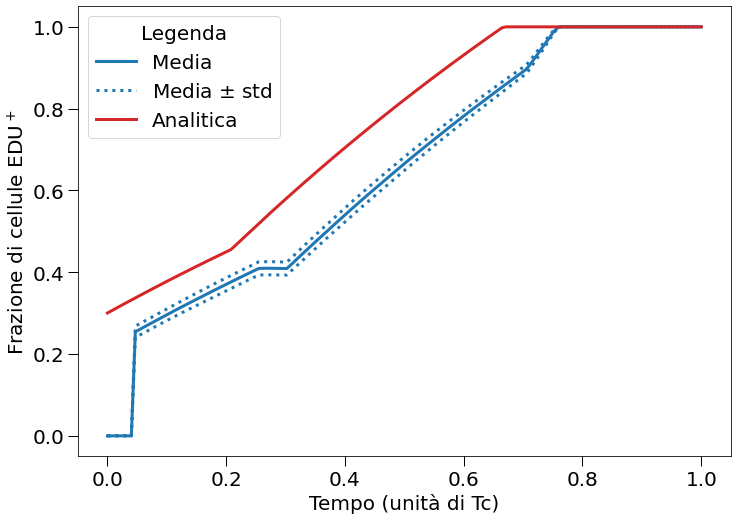

. . . . . . . . . . 


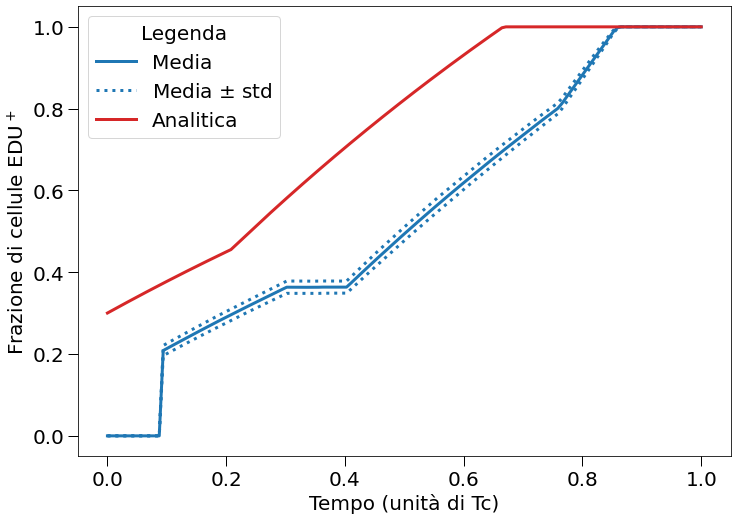

In [2]:
Tc = 1.
time_deltas = [ x * Tc for x in [0.01, 0.02, 0.05, 0.1] ]

np.random.seed(0)

for time_delta in time_deltas:
    # Repeat simulation N times to get mean and std
    N_simulations = 1000
    # parameters for the simulation
    N_cells = 1000
    T_tot = 1.
    N_timesteps = 150
    #single runs results
    # num rows = N_timestep
    # num cols = N_simulation
    # results[i][j] = result at time i for simulation j 
    results = [ [] for _ in range(N_timesteps)]
    
    #All runs results
    mean = []
    std = []
    
    # Simulate
    for _ in range(N_simulations):
        # Progress bar
        progress = N_simulations/10
        if _%progress == 0:
            print(".", end=" ")
        if _ == N_simulations - 1 :
            print()
        # Single run
        exp = EDU_deterministic_experiment(T_tot = T_tot, N_cells = N_cells, time_delta = time_delta)
        exp.run_experiment(N_timesteps = N_timesteps)
        # save data
        for i in range(N_timesteps) :
            results[i].append(exp._positive_fraction[i])
            
    # process results
    for i in range(N_timesteps) :
        mean.append(np.mean(results[i]))
        std.append(np.std(results[i]))
    
    # Plot results
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(1, 1, 1)
    
    ## set ticks
    ax.tick_params(which='major', width=1.0, labelsize=20)
    ax.tick_params(which='major', length=10, labelsize=20)
    
    times = np.linspace(0., T_tot, num = N_timesteps)
    mean_plus_std = [mean[i] + std[i] for i in range(N_timesteps)]
    mean_minus_std = [mean[i] - std[i] for i in range(N_timesteps)]
    ax.plot(times, mean, color = "tab:blue",lw=3, label = "Media")
    ax.plot(times, mean_plus_std,lw=3, color = "tab:blue", ls=":", label =r"Media $\pm$ std")
    ax.plot(times, mean_minus_std,lw=3, color = "tab:blue", ls=":")
    #plt.axvline(x= (exp._TG1 + exp._TG2M), label=r"$T_{G_1}+T_{(G_2+M)}$", color = "red", ls = "--")
    #plt.axvline(x= exp._TG2M, label=r"$T_{(G2+M)}$", color = "orange", ls = "--")
    
    # Plot analytic solution for the deterministic model
    f = []
    for t in exp._times:
        if t < exp._TG2M : # t < T_G2M
            f.append(math.pow(2., (exp._TG2M + exp._TS)/exp._Tc) 
                    - math.pow(2., (exp._TG2M - t)/exp._Tc)
                    )
        else: # t > T_G2M
            if t < (exp._Tc - exp._TS) : # T_G2M <= t < (T_c - T_S)
                f.append(1. - (math.pow(2., (exp._TG2M + exp._Tc - t)/exp._Tc)
                                - math.pow(2., (exp._TG2M + exp._TS)/exp._Tc)
                                )
                        )
            else: # t >= (T_c - T_S)
                f.append(1.)
        
    ax.plot(exp._times, f, label = "Analitica", color = "tab:red", lw=3)
    ax.legend(fontsize=20, title='Legenda',title_fontsize=20)

    plt.tight_layout()
    
    ax.set_ylabel(r"Frazione di cellule EDU${}^+$", fontsize=20)
    ax.set_xlabel("Tempo (unità di Tc)", fontsize=20)
    ax.yaxis.offsetText.set_fontsize(20)
    #plt.savefig("deterministic_EDU_time_delta_"+str(time_delta/exp._Tc)+".pdf")
    plt.show()